<a href="https://colab.research.google.com/github/shy222/DSCI498-Final-Project/blob/main/DSCI498_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#Installing necessary libraries
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline
import tensorflow_datasets as tfds

from matplotlib import gridspec


Loaded the "RockPaperScissors" dataset from Tensorflow Datasets

In [3]:
ds = tfds.load('RockPaperScissors', split='train', as_supervised=True, shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete0MQ55Q/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete0MQ55Q/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


Shuffled the dataset to ensure randomness.

In [4]:
ds = ds.shuffle(1000).batch(128)

Each image has a shape of (300, 300, 3), indicating height, width, and
3 color channels (RGB).

The target variable (label) in each element of the dataset is represented as a tensor with a shape of (None,) and a data type of int64. This means that the target variable is a one-dimensional array (vector) with a variable batch size, where each element corresponds to a specific class or category.

In [5]:
ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

This label_dict dictionary maps the integer labels to their corresponding class names in the dataset.

In [6]:
# Create dictionary of target classes
label_dict = {
 0: 'Rock',
 1: 'Paper',
 2: 'Scissors'
}

Creates a visualization of a batch of images from the dataset along with their corresponding labels

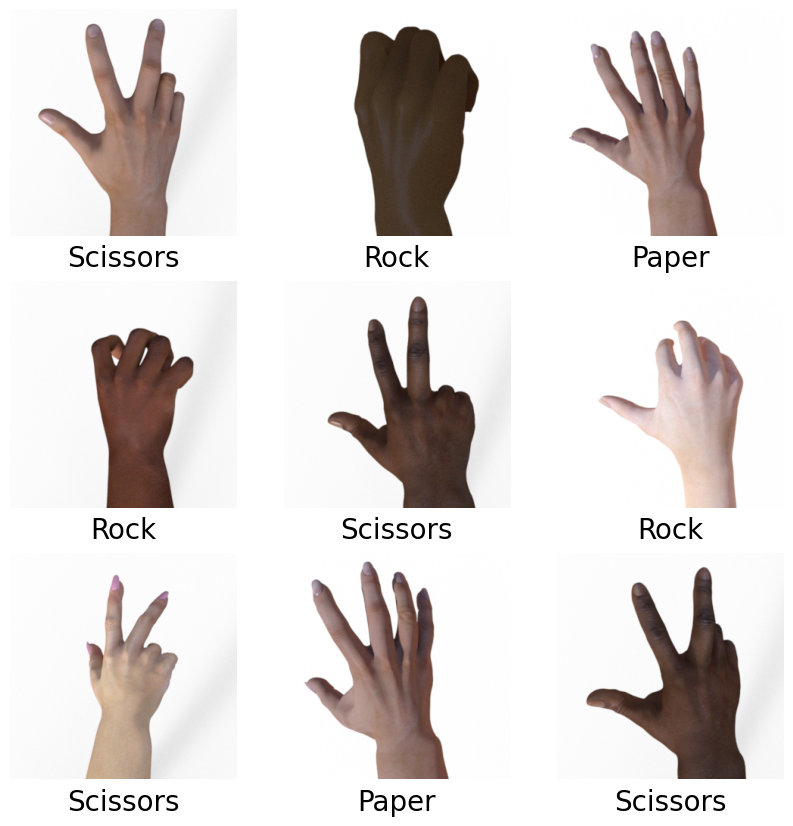

In [9]:
plt.figure(figsize=(10, 10))
for image, label in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        lab = np.array(label[i])
        plt.text(0.5, -0.1, s = label_dict[int(lab)], horizontalalignment='center',
     verticalalignment='center', transform = ax.transAxes, fontsize=20)
        plt.imshow(image[i])
        plt.axis("off")